In [1]:
#load package
using Revise
using Plots
using LaTeXStrings
using LinearAlgebra
using SparseIR
using Nevanlinna

[ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]


In [2]:
# Set work data Type
T = BigFloat
setprecision(128)
;

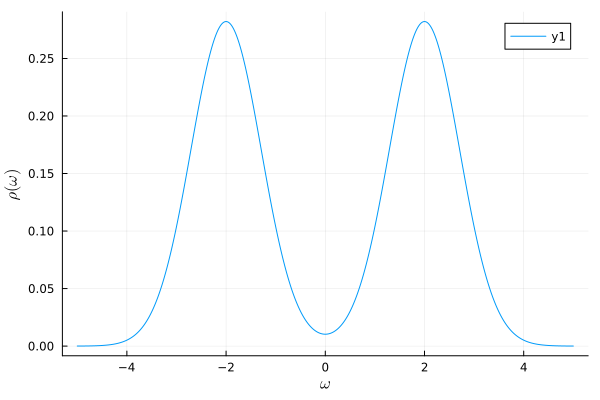

In [3]:
#define spectral function
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
rho(omega) = 0.5*gaussian(omega, -2.0, 1.0) + 0.5*gaussian(omega, 2.0, 1.0)
omegas = LinRange(-5, 5, 1000)
plot()
plot!(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
function generate_input_data(rho::Function, beta::Float64)
    lambda = 1e+4
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

    rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
    gl = - basis.basis_f.s .* rhol
    gw = evaluate(basis.smpl_wn_f, gl)
    
    hnw = length(basis.smpl_wn_f.sampling_points)÷2
    
    input_smpl = Array{Complex{T}}(undef, hnw) 
    input_gw   = Array{Complex{T}}(undef, hnw) 
    
    for i in 1:hnw
        input_smpl[i]= SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], beta)
        input_gw[i]  = gw[hnw+i]
    end
    
    return input_smpl, input_gw
end

generate_input_data (generic function with 1 method)

In [5]:
beta = 100. #inverse temperature
input_smpl, input_gw = generate_input_data(rho, beta)
;

In [6]:
N_real    = 1000  #demension of array of output
omega_max = 10.0  #energy cutoff of real axis
eta       = 0.001 #broaden parameter 
sum_rule  = 1.0   #sum rule
H_max     = 50    #cutoff of Hardy basis
lambda    = 1e-4  #regularization parameter
iter_tol  = 1000  #upper bound of iteration
;

In [7]:
#construct solver struct
@time sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true)
;

N_imag is setted as 31
H=1
Iter     Function value   Gradient norm 
     0     6.000546e+00     1.275561e+01
 * time: 0.026814937591552734
     1     5.419133e+00     2.263283e-01
 * time: 1.5675849914550781
     2     4.393751e+00     9.047356e-02
 * time: 2.216789960861206
     3     4.356191e+00     1.213704e-01
 * time: 2.4841837882995605
     4     4.334485e+00     5.833314e-02
 * time: 2.723879814147949
     5     4.324965e+00     6.274716e-02
 * time: 2.9807398319244385
     6     4.304143e+00     3.311925e-02
 * time: 3.2491369247436523
     7     4.301933e+00     1.738526e-02
 * time: 3.4024879932403564
     8     4.301079e+00     6.479673e-03
 * time: 3.670527935028076
     9     4.300863e+00     5.660547e-03
 * time: 3.9292190074920654
    10     4.300708e+00     2.507824e-03
 * time: 4.155241012573242
    11     4.300686e+00     4.557520e-04
 * time: 4.345628976821899
    12     4.300685e+00     2.030807e-04
 * time: 4.595047950744629
    13     4.300685e+00     6.019903e-0

    93     4.103180e+00     1.433116e-07
 * time: 24.71123695373535
    94     4.103180e+00     9.360075e-08
 * time: 24.902103900909424
    95     4.103180e+00     1.081705e-07
 * time: 25.074947834014893
    96     4.103180e+00     6.923225e-08
 * time: 25.268089056015015
    97     4.103180e+00     8.603525e-08
 * time: 25.47613286972046
    98     4.103180e+00     5.185929e-08
 * time: 25.683645009994507
    99     4.103180e+00     6.020067e-08
 * time: 25.85696005821228
   100     4.103180e+00     3.605627e-08
 * time: 26.002995014190674
   101     4.103180e+00     3.524827e-08
 * time: 26.17177700996399
   102     4.103180e+00     2.101153e-08
 * time: 26.37554383277893
   103     4.103180e+00     1.713644e-08
 * time: 26.556692838668823
   104     4.103180e+00     9.901620e-09
 * time: 26.763104915618896
max_theta=10.74089375740558574151099444027590500811
hardy optimization was failure.
H=3
Iter     Function value   Gradient norm 
     0     6.000546e+00     1.275561e+01
 * time

In [8]:
#execute optimize
@time Nevanlinna.solve!(sol)

H=3
Iter     Function value   Gradient norm 
     0     5.963614e-02     2.601276e-09
 * time: 0.00021696090698242188
max_theta=0.5123688881827098748072003008509919121169
hardy optimization was success.
H=4
Iter     Function value   Gradient norm 
     0     5.963614e-02     2.715936e-01
 * time: 0.00021409988403320312
     1     2.878272e-02     1.183785e-01
 * time: 0.2137000560760498
     2     1.597867e-02     2.659136e-02
 * time: 0.43497514724731445
     3     1.491906e-02     5.980783e-03
 * time: 0.6700830459594727
     4     1.484478e-02     5.825659e-03
 * time: 1.0370922088623047
     5     1.478709e-02     6.490455e-03
 * time: 1.332975149154663
     6     1.465120e-02     6.978803e-03
 * time: 1.6824991703033447
     7     1.458933e-02     3.441222e-03
 * time: 2.008100986480713
     8     1.456809e-02     9.686571e-04
 * time: 2.350919008255005
     9     1.456629e-02     3.262763e-04
 * time: 2.5194389820098877
    10     1.456614e-02     8.467150e-05
 * time: 2.87574720

    25     1.814930e-04     1.136447e-06
 * time: 10.457096099853516
    26     1.814930e-04     4.209768e-07
 * time: 10.892038106918335
    27     1.814930e-04     1.073839e-07
 * time: 11.205039024353027
    28     1.814930e-04     2.106172e-08
 * time: 11.486050128936768
    29     1.814930e-04     9.923709e-09
 * time: 11.899566173553467
max_theta=0.5890382923111933193345087805624117684338
hardy optimization was success.
H=9
Iter     Function value   Gradient norm 
     0     1.814930e-04     6.178807e-03
 * time: 0.00021600723266601562
     1     1.714013e-04     3.030275e-03
 * time: 0.33173704147338867
     2     1.636898e-04     1.924547e-03
 * time: 0.6258928775787354
     3     1.538881e-04     1.131555e-03
 * time: 1.1190180778503418
     4     1.499540e-04     9.477907e-04
 * time: 1.4471569061279297
     5     1.491496e-04     6.540087e-04
 * time: 1.7311980724334717
     6     1.476241e-04     7.248036e-04
 * time: 2.2416129112243652
     7     1.452500e-04     8.998771e

    28     6.579419e-05     2.547704e-06
 * time: 17.720185041427612
    29     6.579417e-05     2.322996e-06
 * time: 18.34000515937805
    30     6.579415e-05     2.191566e-06
 * time: 18.907588958740234
    31     6.579411e-05     3.893314e-06
 * time: 19.503458976745605
    32     6.579403e-05     6.024794e-06
 * time: 20.082371950149536
    33     6.579385e-05     1.060089e-05
 * time: 20.625988006591797
    34     6.579354e-05     1.519357e-05
 * time: 21.218111038208008
    35     6.579283e-05     2.388139e-05
 * time: 21.758893966674805
    36     6.579158e-05     3.304350e-05
 * time: 22.34538197517395
    37     6.578872e-05     4.913429e-05
 * time: 22.888684034347534
    38     6.578367e-05     6.789942e-05
 * time: 23.477635145187378
    39     6.577207e-05     9.967015e-05
 * time: 24.058905124664307
    40     6.575141e-05     1.311255e-04
 * time: 24.665946006774902
    41     6.570435e-05     1.654751e-04
 * time: 25.23591899871826
    42     6.562291e-05     1.473833e

    24     6.195697e-05     5.361971e-05
 * time: 16.835750818252563
    25     6.191551e-05     4.879380e-05
 * time: 17.74470281600952
    26     6.189022e-05     7.219817e-05
 * time: 18.414642810821533
    27     6.179315e-05     9.926160e-05
 * time: 19.288578033447266
    28     6.176717e-05     5.304676e-05
 * time: 19.92550492286682
    29     6.175376e-05     3.617727e-05
 * time: 20.59399700164795
    30     6.174948e-05     2.053936e-05
 * time: 21.223833799362183
    31     6.174843e-05     1.146537e-05
 * time: 21.679608821868896
    32     6.174735e-05     1.644199e-05
 * time: 22.362411975860596
    33     6.174595e-05     2.457554e-05
 * time: 23.06163501739502
    34     6.174235e-05     3.962566e-05
 * time: 23.772313833236694
    35     6.173764e-05     5.223141e-05
 * time: 24.421855926513672
    36     6.172706e-05     8.305070e-05
 * time: 25.09703803062439
    37     6.171247e-05     1.053150e-04
 * time: 25.763355016708374
    38     6.168001e-05     1.523710e-0

    61     6.089110e-05     9.445053e-08
 * time: 44.109143018722534
    62     6.089110e-05     8.368821e-08
 * time: 45.345640897750854
    63     6.089110e-05     9.462961e-08
 * time: 46.09857106208801
    64     6.089110e-05     1.561208e-07
 * time: 46.86643886566162
    65     6.089110e-05     2.083846e-07
 * time: 47.51058793067932
    66     6.089110e-05     3.163514e-07
 * time: 48.17223286628723
    67     6.089110e-05     4.039468e-07
 * time: 48.79727387428284
    68     6.089110e-05     5.681181e-07
 * time: 49.46564197540283
    69     6.089109e-05     7.026999e-07
 * time: 50.1273238658905
    70     6.089109e-05     9.469504e-07
 * time: 50.803125858306885
    71     6.089109e-05     1.155890e-06
 * time: 51.48551893234253
    72     6.089109e-05     1.527785e-06
 * time: 52.28625702857971
    73     6.089109e-05     1.851044e-06
 * time: 53.04423689842224
    74     6.089108e-05     2.417430e-06
 * time: 53.729004859924316
    75     6.089108e-05     2.909850e-06
 * t

    78     6.074068e-05     7.327533e-07
 * time: 56.87440586090088
    79     6.074068e-05     2.955308e-07
 * time: 57.36815094947815
    80     6.074068e-05     1.849896e-07
 * time: 58.05695199966431
    81     6.074068e-05     8.398730e-08
 * time: 58.51077890396118
    82     6.074068e-05     5.722481e-08
 * time: 59.23320198059082
    83     6.074068e-05     2.610002e-08
 * time: 59.67049598693848
    84     6.074068e-05     3.957950e-08
 * time: 60.358412981033325
    85     6.074068e-05     3.914848e-08
 * time: 60.857818841934204
    86     6.074068e-05     8.855925e-08
 * time: 61.56648278236389
    87     6.074068e-05     9.658691e-08
 * time: 62.05346989631653
    88     6.074068e-05     1.674904e-07
 * time: 62.74046993255615
    89     6.074068e-05     1.809136e-07
 * time: 63.161780834198
    90     6.074068e-05     3.252852e-07
 * time: 63.85824179649353
    91     6.074068e-05     3.480055e-07
 * time: 64.32340383529663
    92     6.074068e-05     5.325971e-07
 * time

    74     6.071085e-05     4.372555e-06
 * time: 62.39511680603027
    75     6.071083e-05     4.643067e-06
 * time: 62.91947889328003
    76     6.071078e-05     6.830767e-06
 * time: 63.69218397140503
    77     6.071074e-05     7.270617e-06
 * time: 64.21370887756348
    78     6.071064e-05     1.038122e-05
 * time: 64.93882989883423
    79     6.071055e-05     1.102157e-05
 * time: 65.41955590248108
    80     6.071034e-05     1.531774e-05
 * time: 66.2459328174591
    81     6.071016e-05     1.621316e-05
 * time: 66.8124988079071
    82     6.070974e-05     2.189154e-05
 * time: 67.56884002685547
    83     6.070938e-05     2.306854e-05
 * time: 68.11646485328674
    84     6.070856e-05     3.002801e-05
 * time: 68.83381581306458
    85     6.070787e-05     3.138430e-05
 * time: 69.38495683670044
    86     6.070628e-05     3.800857e-05
 * time: 70.1978178024292
    87     6.070493e-05     3.860224e-05
 * time: 70.97156095504761
    88     6.070142e-05     3.610114e-05
 * time: 7

    88     6.068584e-05     1.196920e-07
 * time: 62.26129698753357
    89     6.068584e-05     1.315533e-07
 * time: 62.75253105163574
    90     6.068584e-05     1.794995e-07
 * time: 63.51235294342041
    91     6.068584e-05     1.967273e-07
 * time: 64.03029894828796
    92     6.068584e-05     2.576832e-07
 * time: 64.76740598678589
    93     6.068584e-05     2.814242e-07
 * time: 65.30823993682861
    94     6.068584e-05     3.600273e-07
 * time: 66.1046359539032
    95     6.068584e-05     3.911998e-07
 * time: 66.61552000045776
    96     6.068584e-05     4.916877e-07
 * time: 67.45192503929138
    97     6.068584e-05     5.327302e-07
 * time: 68.55507588386536
    98     6.068584e-05     6.616230e-07
 * time: 69.60515093803406
    99     6.068584e-05     7.154227e-07
 * time: 70.12056088447571
   100     6.068584e-05     8.807625e-07
 * time: 70.90566205978394
   101     6.068584e-05     9.503522e-07
 * time: 71.42371582984924
   102     6.068584e-05     1.162287e-06
 * time:

    76     6.067940e-05     2.680640e-06
 * time: 54.38808512687683
    77     6.067940e-05     3.164700e-06
 * time: 54.9782030582428
    78     6.067939e-05     3.490388e-06
 * time: 55.48699498176575
    79     6.067938e-05     4.080582e-06
 * time: 56.03117299079895
    80     6.067937e-05     4.492515e-06
 * time: 56.57599115371704
    81     6.067936e-05     5.198912e-06
 * time: 57.60760998725891
    82     6.067934e-05     5.704296e-06
 * time: 58.121586084365845
    83     6.067932e-05     6.569558e-06
 * time: 59.1655330657959
    84     6.067929e-05     7.202986e-06
 * time: 59.93751001358032
    85     6.067926e-05     8.258053e-06
 * time: 61.22504901885986
    86     6.067922e-05     9.055161e-06
 * time: 61.878666162490845
    87     6.067917e-05     1.034711e-05
 * time: 62.748709201812744
    88     6.067910e-05     1.135185e-05
 * time: 63.33646297454834
    89     6.067901e-05     1.295765e-05
 * time: 64.13223505020142
    90     6.067890e-05     1.422668e-05
 * tim

   196     6.067130e-05     3.008191e-06
 * time: 139.9013650417328
   197     6.067130e-05     3.572106e-06
 * time: 140.75722813606262
   198     6.067129e-05     3.748182e-06
 * time: 141.30785512924194
   199     6.067128e-05     4.448953e-06
 * time: 142.09268617630005
   200     6.067127e-05     4.668692e-06
 * time: 142.67478919029236
   201     6.067126e-05     5.540480e-06
 * time: 143.45706915855408
   202     6.067125e-05     5.815038e-06
 * time: 143.98780798912048
   203     6.067122e-05     6.900914e-06
 * time: 144.7841100692749
   204     6.067120e-05     7.244495e-06
 * time: 145.33827710151672
   205     6.067117e-05     8.599041e-06
 * time: 146.13885712623596
   206     6.067114e-05     9.029915e-06
 * time: 146.6994481086731
   207     6.067108e-05     1.072267e-05
 * time: 147.43434405326843
   208     6.067103e-05     1.126460e-05
 * time: 147.9443850517273
   209     6.067094e-05     1.338457e-05
 * time: 148.7512490749359
   210     6.067086e-05     1.406886e-0

    72     6.061244e-05     3.361591e-06
 * time: 52.08097696304321
    73     6.061237e-05     5.654734e-06
 * time: 52.88057494163513
    74     6.061233e-05     5.113540e-06
 * time: 53.425686836242676
    75     6.061225e-05     7.655908e-06
 * time: 54.22423982620239
    76     6.061218e-05     7.262884e-06
 * time: 54.75281381607056
    77     6.061206e-05     9.694563e-06
 * time: 55.57095193862915
    78     6.061196e-05     9.701331e-06
 * time: 56.05333089828491
    79     6.061169e-05     1.145596e-05
 * time: 56.88394498825073
    80     6.061128e-05     1.069313e-05
 * time: 57.662837982177734
    81     6.061073e-05     9.432581e-06
 * time: 58.46709585189819
    82     6.061050e-05     3.869908e-06
 * time: 59.011616945266724
    83     6.061043e-05     2.939712e-06
 * time: 59.80787181854248
    84     6.061041e-05     1.520898e-06
 * time: 60.362897872924805
    85     6.061040e-05     1.403949e-06
 * time: 61.14647698402405
    86     6.061039e-05     6.185353e-07
 * 

   192     6.057385e-05     1.096950e-06
 * time: 131.70176887512207
   193     6.057385e-05     5.454497e-07
 * time: 132.2655827999115
   194     6.057385e-05     4.912585e-07
 * time: 132.78068590164185
   195     6.057385e-05     2.447523e-07
 * time: 133.29779195785522
   196     6.057385e-05     2.217023e-07
 * time: 133.81654596328735
   197     6.057385e-05     1.186664e-07
 * time: 134.3400809764862
   198     6.057385e-05     9.419848e-08
 * time: 134.85342383384705
   199     6.057385e-05     5.206256e-08
 * time: 135.3744649887085
   200     6.057385e-05     4.436159e-08
 * time: 135.87996792793274
   201     6.057385e-05     2.153745e-08
 * time: 136.43923687934875
   202     6.057385e-05     2.100110e-08
 * time: 136.89730191230774
   203     6.057385e-05     9.640861e-09
 * time: 137.49411392211914
max_theta=0.6813243341933695813991531822261149360776
hardy optimization was success.
H=20
Iter     Function value   Gradient norm 
     0     6.057385e-05     9.673761e-05
 * 

   106     6.036291e-05     6.531730e-06
 * time: 77.30966305732727
   107     6.036275e-05     5.012008e-06
 * time: 77.82043194770813
   108     6.036268e-05     2.898055e-06
 * time: 78.34868812561035
   109     6.036264e-05     2.642029e-06
 * time: 78.93849110603333
   110     6.036263e-05     1.376398e-06
 * time: 79.43275499343872
   111     6.036262e-05     1.256239e-06
 * time: 80.03028917312622
   112     6.036261e-05     6.822723e-07
 * time: 80.52569603919983
   113     6.036261e-05     6.406796e-07
 * time: 81.11527800559998
   114     6.036261e-05     3.480076e-07
 * time: 81.69651103019714
   115     6.036261e-05     4.073429e-07
 * time: 82.17879509925842
   116     6.036261e-05     2.541641e-07
 * time: 82.74797701835632
   117     6.036261e-05     4.527172e-07
 * time: 83.53787517547607
   118     6.036261e-05     4.196942e-07
 * time: 84.12717294692993
   119     6.036260e-05     6.222427e-07
 * time: 84.91577816009521
   120     6.036260e-05     6.008922e-07
 * time

   226     6.031364e-05     3.748362e-06
 * time: 152.0910120010376
   227     6.031363e-05     3.973488e-06
 * time: 152.69373512268066
   228     6.031363e-05     4.237231e-06
 * time: 153.20952796936035
   229     6.031362e-05     4.488580e-06
 * time: 153.80418610572815
   230     6.031362e-05     4.783008e-06
 * time: 154.28904700279236
   231     6.031361e-05     5.063694e-06
 * time: 154.86691999435425
   232     6.031360e-05     5.392445e-06
 * time: 155.403174161911
   233     6.031359e-05     5.705992e-06
 * time: 155.9336609840393
   234     6.031359e-05     6.073152e-06
 * time: 156.49595403671265
   235     6.031357e-05     6.423510e-06
 * time: 157.0447940826416
   236     6.031356e-05     6.833714e-06
 * time: 157.57718205451965
   237     6.031355e-05     7.225332e-06
 * time: 158.1626091003418
   238     6.031354e-05     7.683839e-06
 * time: 158.67351698875427
   239     6.031352e-05     8.121767e-06
 * time: 159.2322449684143
   240     6.031350e-05     8.634521e-06


   346     6.017342e-05     1.310708e-06
 * time: 228.52878499031067
   347     6.017341e-05     1.484357e-06
 * time: 229.37647795677185
   348     6.017341e-05     1.515186e-06
 * time: 229.88742399215698
   349     6.017341e-05     1.714633e-06
 * time: 230.75147414207458
   350     6.017341e-05     1.750301e-06
 * time: 231.2887270450592
   351     6.017341e-05     1.979446e-06
 * time: 232.14263606071472
   352     6.017341e-05     2.020684e-06
 * time: 232.67100501060486
   353     6.017341e-05     2.284017e-06
 * time: 233.49708199501038
   354     6.017341e-05     2.331668e-06
 * time: 234.00828003883362
   355     6.017340e-05     2.634357e-06
 * time: 234.8483591079712
   356     6.017340e-05     2.689397e-06
 * time: 235.33199906349182
   357     6.017340e-05     3.037409e-06
 * time: 236.18714714050293
   358     6.017339e-05     3.100965e-06
 * time: 236.73527908325195
   359     6.017339e-05     3.501202e-06
 * time: 237.52437710762024
   360     6.017339e-05     3.574573

In [9]:
wo_sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
;

N_imag is setted as 31


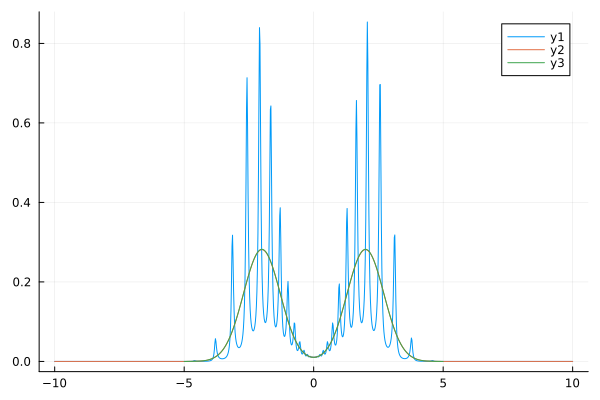

In [10]:
plot()
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

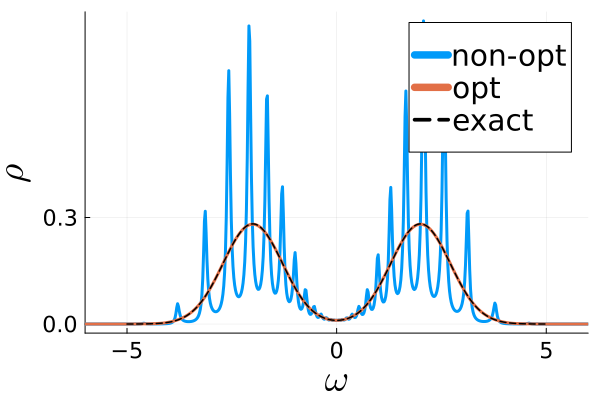

In [12]:
plot(xlim = [-6,6],
    legend = :topright,
    #ymirror = true, 
    xticks = [5,0,-5],
    yticks = [0.3,0,-0.3],
    xtickfont=font(15), 
    ytickfont=font(15), 
    guidefont=font(25), 
    legendfont=font(20))
plot!(xlabel=latexstring("\\omega"))
plot!(ylabel=latexstring("\\rho"))
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val/pi),label="non-opt",lw=3)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val)/pi),label="opt",lw=3)
plot!(omegas, rho.(omegas), label="exact",lw=1.5,ls=:dash,lc=:black)
#savefig("two_peak.svg")